In [1]:
from binance.client import Client
import pytz
import datetime
import dateutil.parser
import pandas as pd
import smtplib 
from stockstats import StockDataFrame
import datetime as dt
from IPython.display import clear_output
import time
import numpy as np
import matplotlib.pyplot as py
import urllib3
from binance.client import Client
import plotly.graph_objects as go
import pandas as pd

In [2]:
def convert_datetime_timezone(dt, tz1, tz2):
    tz1 = pytz.timezone(tz1)
    tz2 = pytz.timezone(tz2)
    dt = datetime.datetime.strptime(dt,'%Y-%m-%d %H:%M:%S')
    dt = tz1.localize(dt)
    dt = dt.astimezone(tz2)
    dt = dt.strftime('%Y-%m-%d %H:%M:%S')
    return dt

In [3]:
def scrap_binance_price(unit,interval):

    api_key = 'LKa422RMjzx2tsXESIoSQ5qJzqi7LaC7iDFf9qdSrYjhJrZ6a8CcvOdniJWtfX13'
    api_secret = 'EvomPthpqwgTjeuqYFWBQM9HtE52Zeq6SuKrZSROqhd8g2tvbz086zVZqbbJGxsZ'

    client = Client(api_key, api_secret, {"verify": False, "timeout": 20})
    klines = client.get_historical_klines("BTCUSDT", unit, interval)

    data = pd.DataFrame();
    tradingdate = []
    openprice = []
    highprice = []
    lowprice = []
    closeprice = [] 
    for i in range(len(klines)):   
        time = datetime.datetime.utcfromtimestamp(klines[i][0]/1000).strftime('%Y-%m-%d %H:%M:%S')
        local_time = convert_datetime_timezone(time,'GMT','Australia/Adelaide')
        format_time = dateutil.parser.parse(local_time)
        tradingdate.append(format_time)
        openprice.append(float(klines[i][1]))
        highprice.append(float(klines[i][2]))
        lowprice.append(float(klines[i][3]))
        closeprice.append(float(klines[i][4]))
    data['datetime'] = tradingdate
    data['low'] = lowprice
    data['high'] = highprice
    data['open'] = openprice
    data['close'] = closeprice
    return data

In [4]:
def heikin_ashi(df):
    
    heikin_ashi_df = pd.DataFrame(index=df.index.values, columns=['open', 'high', 'low', 'close'])
    
    heikin_ashi_df['close'] = (df['open'] + df['high'] + df['low'] + df['close']) / 4
    
    for i in range(len(df)):
        if i == 0:
            heikin_ashi_df.iat[0, 0] = df['open'].iloc[0]
        else:
            heikin_ashi_df.iat[i, 0] = (heikin_ashi_df.iat[i-1, 0] + heikin_ashi_df.iat[i-1, 3]) / 2
        
    heikin_ashi_df['high'] = heikin_ashi_df.loc[:, ['open', 'close']].join(df['high']).max(axis=1)
    
    heikin_ashi_df['low'] = heikin_ashi_df.loc[:, ['open', 'close']].join(df['low']).min(axis=1)
    
    heikin_ashi_df['datetime'] = df['datetime']
    return heikin_ashi_df

In [5]:
def round_down(value, decimals):
    factor = 1 / (10 ** decimals)
    return (value // factor) * factor

In [6]:
def email_notification(message):
    info = pd.read_csv('C:\\Users\\Ray\\Desktop\\E_Info.csv')
    gmailaddress = info['username'][0]
    gmailpassword = info['password'][0]
    mailToOne = info['addressOne'][0]
    mailToTwo = info['addressTwo'][0]
    msg = "Buy the Bitcoin"
    mailServer = smtplib.SMTP('smtp.gmail.com' , 587)
    mailServer.starttls()
    mailServer.login(gmailaddress , gmailpassword)
    mailServer.sendmail(gmailaddress, mailToOne , message)
    #mailServer.sendmail(gmailaddress, mailToTwo , message)
    mailServer.quit()

In [7]:
def trading(treasure,test,money,bitcoin,bnb):
    
    initial_money = money
    initial_bitcoin = bitcoin
    initial_bnb = bnb
    #client.order_market_buy(symbol = 'BTCUSDT',quantity = round_down(initial_bnb,6))
    A = []
    B = []
    C = []
    D = []
    E = []
    F = []
    G = []
    
    commission_rate = 0.00075
    
    test.reset_index(drop = True, inplace = True)
    comission_state = True
    balance = 100
    index = 0
    for i in range (len(test)):
        #set the current transfer index    
        index += 1
        #set the transaction rule
        #set the rule of buy bitcoin
        if(test['indicator'][i] == 1 and money > 0 and comission_state == True and bnb>0):
            if(money/test['close'][i]<balance):
                if(i<len(test)-1):
                    bitcoin_exchange = round_down(money/test['close'][i],6)
                    bnb -= money/18*commission_rate
                    balance -= bitcoin_exchange
                    bitcoin += bitcoin_exchange
                    money -= bitcoin_exchange*test['close'][i]
                    record[test['datetime'][i]] = 1
                else:
                    bitcoin_exchange = round_down(money/test['close'][i],6)
                    bnb -= money/18*commission_rate
                    balance -= bitcoin_exchange
                    bitcoin += bitcoin_exchange
                    money -= bitcoin_exchange*test['close'][i]
                    if(record.get(test['datetime'][i]) != 1):
                        record[test['datetime'][i]] = 1
                        email_notification("Buy the Bitcoin Right Now! -- 1 Hour Economic Model.")
                    #client.order_market_buy(symbol = 'BTCUSDT',quantity = round_down(bitcoin_exchange,6))
            else:
                bitcoin += balance
                money -= balance*test['close'][i]
                bnb -= money/18*commission_rate
                comission_state = False
                record[test['datetime'][i]] = 1
                if(i<len(test)-1):
                    if(record.get(test['datetime'][i]) != 1):
                        record[test['datetime'][i]] = 1
                        email_notification("Buy the Bitcoin Right Now! -- 1 Hour Economic Model.")
                        #client.order_market_buy(symbol = 'BTCUSDT',quantity = round_down(balance,6) )
        #set the rule of sell bitcoin
        elif(test['indicator'][i] == 2 and bitcoin>0 and bnb>0):
            if(i<len(test)-1):
                #each extraction opertion the system would charge commission fee
                bnb -= bitcoin*test['close'][i]/18*commission_rate
                money += bitcoin*test['close'][i]
                bitcoin = 0
                record[test['datetime'][i]] = 2
            else:              
                #each extraction opertion the system would charge commission fee
                bnb -= bitcoin*test['close'][i]/18*commission_rate
                money += bitcoin*test['close'][i]
                bitcoin = 0
                if(record.get(test['datetime'][i]) != 2):
                    record[test['datetime'][i]] = 2
                    email_notification("Sell the Bitcoin Right Now! -- 1 Hour Economic Model.")
                #client.order_market_sell(symbol = 'BTCUSDT',quantity = round_down(bitcoin,6))
        #the system would run 24h daily 
        if(index>=24*4):
            index = 0
            balance = 100
            comission_state = True
            
        A.append(test['datetime'][i]);
        B.append(money)
        C.append(bitcoin)
        D.append(bitcoin*test['close'][i]+money)
        E.append(test['indicator'][i])
        F.append(i+1)
        G.append(test['close'][i])
 
    treasure['datetime'] = A
    treasure['index'] = F
    treasure['money'] = B
    treasure['bitcoin'] = C
    treasure['total'] = D
    treasure['indicator'] = E
    treasure['close'] = G
    
    initial_assert = initial_money+initial_bitcoin*test['close'][0]+initial_bnb*18
    TotalAssert = bitcoin*test['close'][len(test)-1]+money+bnb*18
    TransactionDate = test['datetime'][len(test)-1]-test['datetime'][0]
    print("Initial money is:" + str(initial_money))
    print("Initial bitcoin is:" + str(initial_bitcoin))
    print("Initial bnb is:" + str(initial_bnb))
    print("Investment Start Time:" + str(test['datetime'][0]) )
    print("Investment End Time:" + str(test['datetime'][len(test)-1]) )
    print("Investment Periods: "+str(TransactionDate.days) )
    print("Current Money:" + str(money) )
    print("Current Bitcoin: "+ str(bitcoin) )
    print("Current BNB: "+ str(bnb) )
    print("Return on Investment is:"+ str( (TotalAssert-initial_assert)/initial_assert*100)+"%")
    print("Current Total Assert is: "+ str(TotalAssert) )
    if(TotalAssert/initial_assert<0.9):
        print("Trading curb occured")
        money += bitcoin * test['close'][len(test)-1]*commission_rate
        bnb -= bitcoin*test['close'][len(test)-1]*commission_rate
        bitcoin = 0
        alarm = True
    #return TotalAssert
    

In [8]:
def display_candles(data):

    df = data

    fig = go.Figure(data=[go.Candlestick(x=df['datetime'],
                    open=df['open'],
                    high=df['high'],
                    low=df['low'],
                    close=df['close'])])
    fig.show()


In [9]:
def add_indicator(df1,df2):
    #1: buy indicator
    #2: sell indicator
    #0: hold activity
    #df1: original price dataset
    #df2: heikin-ashi price dataset
    point = []
    second_previous = 0
    first_previous = 0
    current = 0
    #MACD_EMA_SHORT: default to 12
    #MACD_EMA_LONG: default to 26
    #MACD_EMA_SIGNAL: default to 9
    point.append(0)
    hasBitcoin = True
    candle_color = ''
    pre_candle_color = ''
    for i in range(1,len(df2)):
        previous_open = df2['open'][i-1];
        previous_close = df2['close'][i-1];
        current_close = df2['close'][i]
        current_low = df2['low'][i]
        current_high = df2['high'][i]
        current_open = df2['open'][i]
        
        #define the color of candles
        if(previous_close > previous_open):
            pre_candle_color = 'green'
        else:
            pre_candle_color = 'red'
            
        if(current_close > current_open):
            candle_color = 'green'
        else:
            candle_color = 'red'
            
        #define the candle and wicks
        if(candle_color == 'green'):
            up_wicks = current_high - current_close
            down_wicks = current_open - current_low
            candle = current_close - current_open
            total_candle = current_high - current_low      
        else:
            up_wicks = current_high - current_open
            down_wicks = current_close - current_low
            candle = current_open - current_close
            total_candle = current_high - current_low
        
        if(candle_color == 'green' and down_wicks < 0.1 * total_candle and candle > 0.3 * total_candle and total_candle/current_high>0.02 and hasBitcoin == False):
            point.append(1)
            hasBitcoin = True
        elif(candle_color == 'red' and up_wicks < 0.1 * total_candle and candle > 0.3 * total_candle and hasBitcoin == True):
            point.append(2)
            hasBitcoin = False
        else:
            point.append(0)
    df1['indicator'] = point
    return df1

In [10]:
def run_bot(time_interval,time_interval_name,time_range,record):


    urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
    pd.set_option('display.float_format',lambda x : '%.2f' % x)

    api_key = 'LKa422RMjzx2tsXESIoSQ5qJzqi7LaC7iDFf9qdSrYjhJrZ6a8CcvOdniJWtfX13'
    api_secret = 'EvomPthpqwgTjeuqYFWBQM9HtE52Zeq6SuKrZSROqhd8g2tvbz086zVZqbbJGxsZ'

    client = Client(api_key, api_secret, {"verify": False, "timeout": 20})
    money = 500
    bitcoin = 0
    #bnb=bitcoin*0.3/0.002
    bnb = 5
    alarm = False
    initial_data = scrap_binance_price(time_interval,time_range)
    data = initial_data[:len(initial_data)-1]
    #loop
    code = 0
    while(bnb>0):
        #try:
        latest_data = scrap_binance_price(time_interval, time_interval_name+" ago UTC")
        if(data['datetime'][len(data)-1] == latest_data['datetime'][0]):
            data.drop(data.index[len(data)-1],inplace = True)
        data = pd.concat([data, latest_data], axis=0, join='outer', ignore_index=False, keys=None,
                  levels=None, names=None, verify_integrity=False, copy=True)
        data.reset_index(drop = True, inplace = True)
        heikin_ashi_data = data.copy()
        heikin_ashi_info = heikin_ashi(heikin_ashi_data)
        candle_sticks = data.copy()
        test = add_indicator(candle_sticks,heikin_ashi_info)
        treasure = pd.DataFrame()
        trading(treasure,test,money,bitcoin,bnb)

        x_positive = []
        y_positive = []
        yp_positive = []
        x_negative = []
        y_negative = []  
        yp_negative = []
        for i in range(len(treasure)):
            if(treasure['indicator'][i] == 1):
                x_positive.append(treasure['index'][i])
                y_positive.append(treasure['total'][i])
                yp_positive.append(treasure['close'][i])
            elif(treasure['indicator'][i] == 2):
                x_negative.append(treasure['index'][i])
                y_negative.append(treasure['total'][i])
                yp_negative.append(treasure['close'][i])

        #assert growth graph
        fig_assert = py.figure(figsize=(20,10))
        x = treasure['index'].values.tolist()
        y = treasure['total'].values.tolist()
        py.xticks(([0,len(treasure)//4,len(treasure)//4*2,len(treasure)//4*3,len(treasure)//4*4]), (str(treasure['datetime'][0]),str(treasure['datetime'][len(treasure)//4]),str(treasure['datetime'][len(treasure)//4*2]),str(treasure['datetime'][len(treasure)//4*3]),str(treasure['datetime'][len(treasure)-1])), rotation=20,fontsize = 20)
        py.yticks(fontsize = 20)
        py.plot(x,y)
        #buy point
        py.scatter(x_positive,y_positive,c='#00CC00',s=80)
        #sell point
        py.scatter(x_negative,y_negative,c='#CC3333',s=80)
        py.xlabel('Transaction Time -- Adelaide Time Zone',fontsize = 20)
        py.ylabel('total assert',fontsize = 20)
        py.show()

        #price flowing graph
        fig_price = py.figure(figsize=(20,10))
        xp = treasure['index'].values.tolist()
        yp = treasure['close'].values.tolist()
        py.xticks(([0,len(treasure)//4,len(treasure)//4*2,len(treasure)//4*3,len(treasure)//4*4]), (str(treasure['datetime'][0]),str(treasure['datetime'][len(treasure)//4]),str(treasure['datetime'][len(treasure)//4*2]),str(treasure['datetime'][len(treasure)//4*3]),str(treasure['datetime'][len(treasure)-1])), rotation=20,fontsize = 20)
        py.yticks(fontsize = 20)
        py.plot(xp,yp)
        #buy point
        py.scatter(x_positive,yp_positive,c='#00CC00',s=80)
        #sell point
        py.scatter(x_negative,yp_negative,c='#CC3333',s=80)
        py.xlabel('Transaction Time -- Adelaide Time Zone',fontsize = 20)
        py.ylabel('close price',fontsize = 20)
        py.show()
        #test.to_csv('1h_indicator.csv',index = None)
        code+=1
        print(record)
        display_candles(heikin_ashi_info)
        break
        if(alarm == True):
            email_notification("Sell the Bitcoin Right Now! -- 1 Hour Economic Model.")
            break
        #except:
        #    print("Something went wrong")
        time.sleep(30)
        clear_output()

Initial money is:500
Initial bitcoin is:0
Initial bnb is:5
Investment Start Time:2019-11-09 11:30:00
Investment End Time:2019-12-09 10:30:00
Investment Periods: 29
Current Money:507.61836251999983
Current Bitcoin: 0
Current BNB: 4.616857493087499
Return on Investment is:0.12233854162285891%
Current Total Assert is: 590.7217973955749


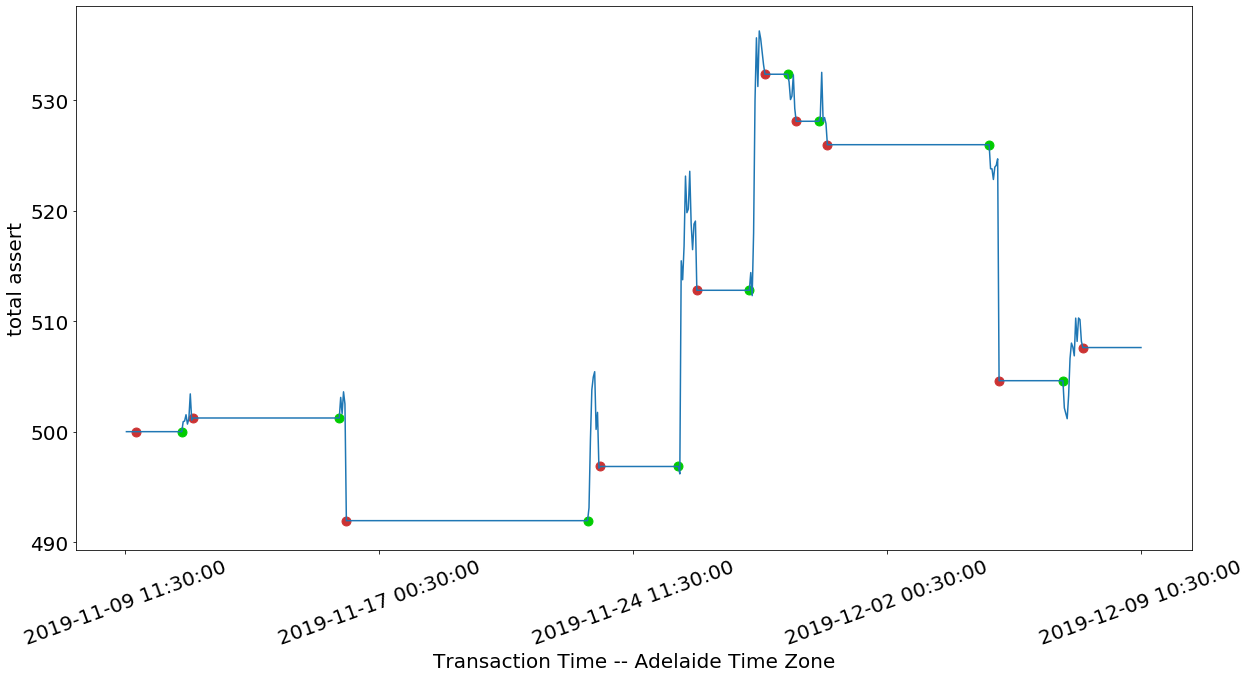

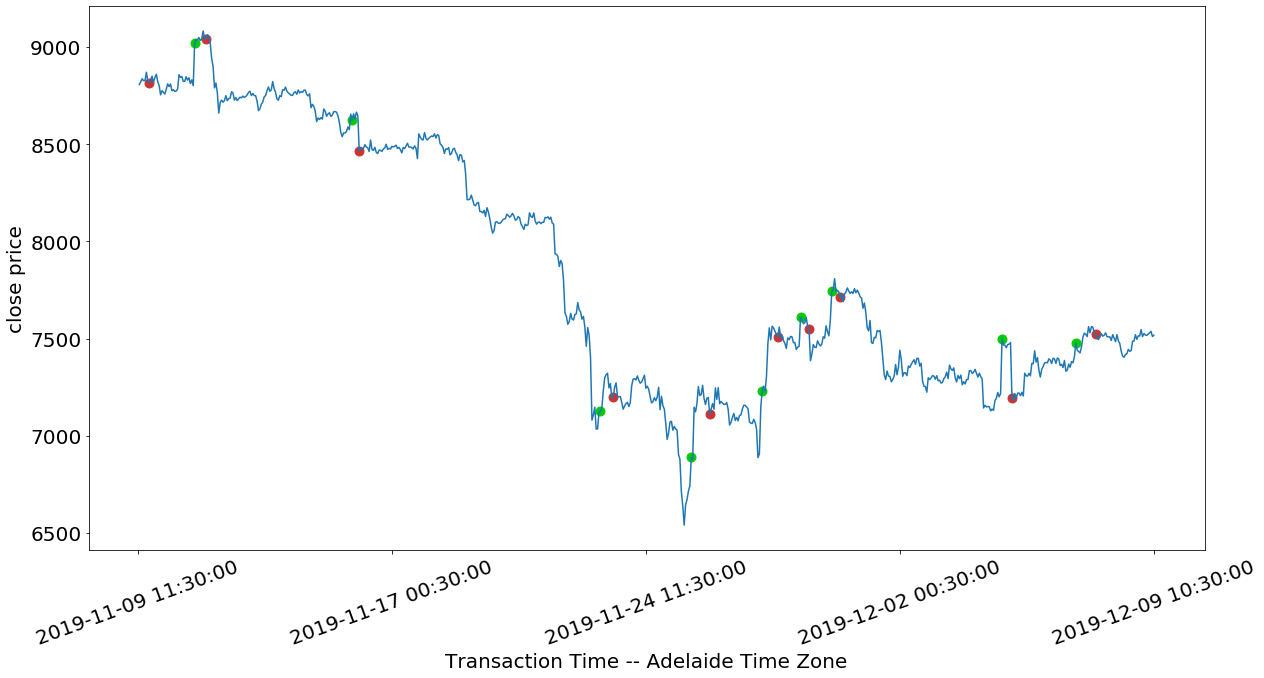

{Timestamp('2019-11-11 02:30:00'): 1, Timestamp('2019-11-11 10:30:00'): 2, Timestamp('2019-11-15 19:30:00'): 1, Timestamp('2019-11-16 00:30:00'): 2, Timestamp('2019-11-23 02:30:00'): 1, Timestamp('2019-11-23 11:30:00'): 2, Timestamp('2019-11-25 20:30:00'): 1, Timestamp('2019-11-26 09:30:00'): 2, Timestamp('2019-11-27 22:30:00'): 1, Timestamp('2019-11-28 09:30:00'): 2, Timestamp('2019-11-29 01:30:00'): 1, Timestamp('2019-11-29 07:30:00'): 2, Timestamp('2019-11-29 23:30:00'): 1, Timestamp('2019-11-30 05:30:00'): 2, Timestamp('2019-12-04 23:30:00'): 1, Timestamp('2019-12-05 06:30:00'): 2, Timestamp('2019-12-07 03:30:00'): 1, Timestamp('2019-12-07 17:30:00'): 2}


In [11]:
record = {}
run_bot('1h','1 hour','1 months ago UTC',record)

Initial money is:500
Initial bitcoin is:0
Initial bnb is:5
Investment Start Time:2019-11-09 12:30:00
Investment End Time:2019-12-09 10:30:00
Investment Periods: 29
Current Money:471.10140686
Current Bitcoin: 0
Current BNB: 4.5927171495475
Return on Investment is:-6.140624482736442%
Current Total Assert is: 553.770315551855


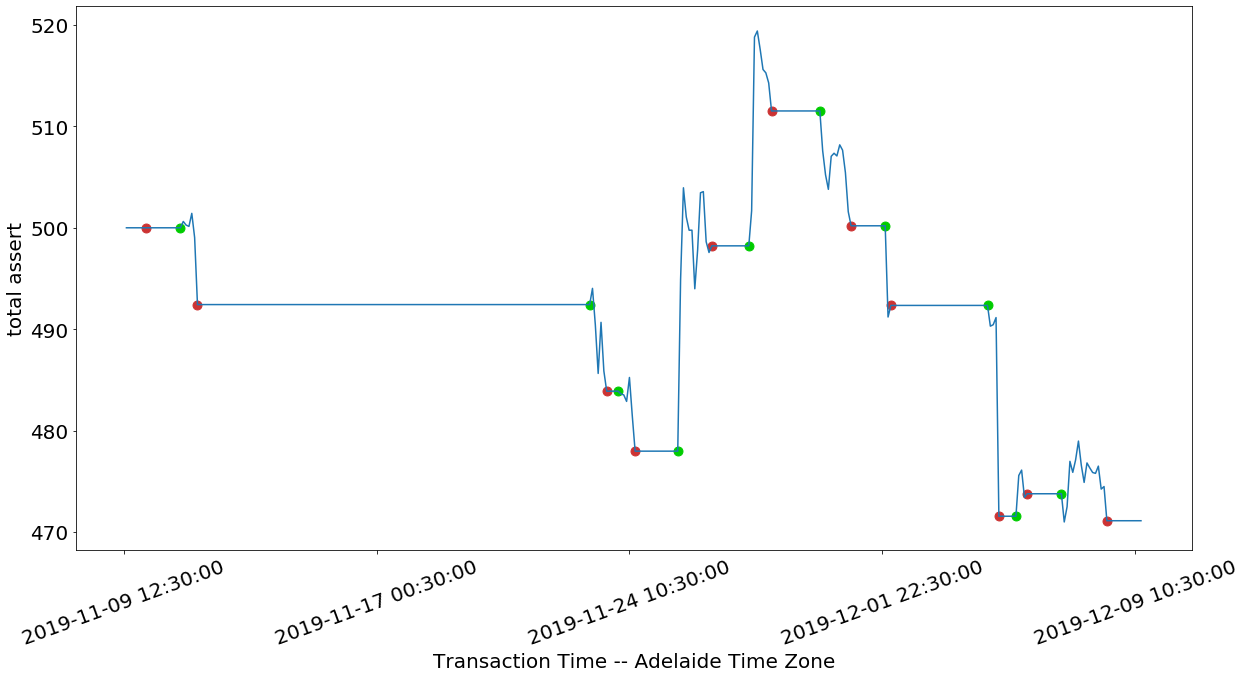

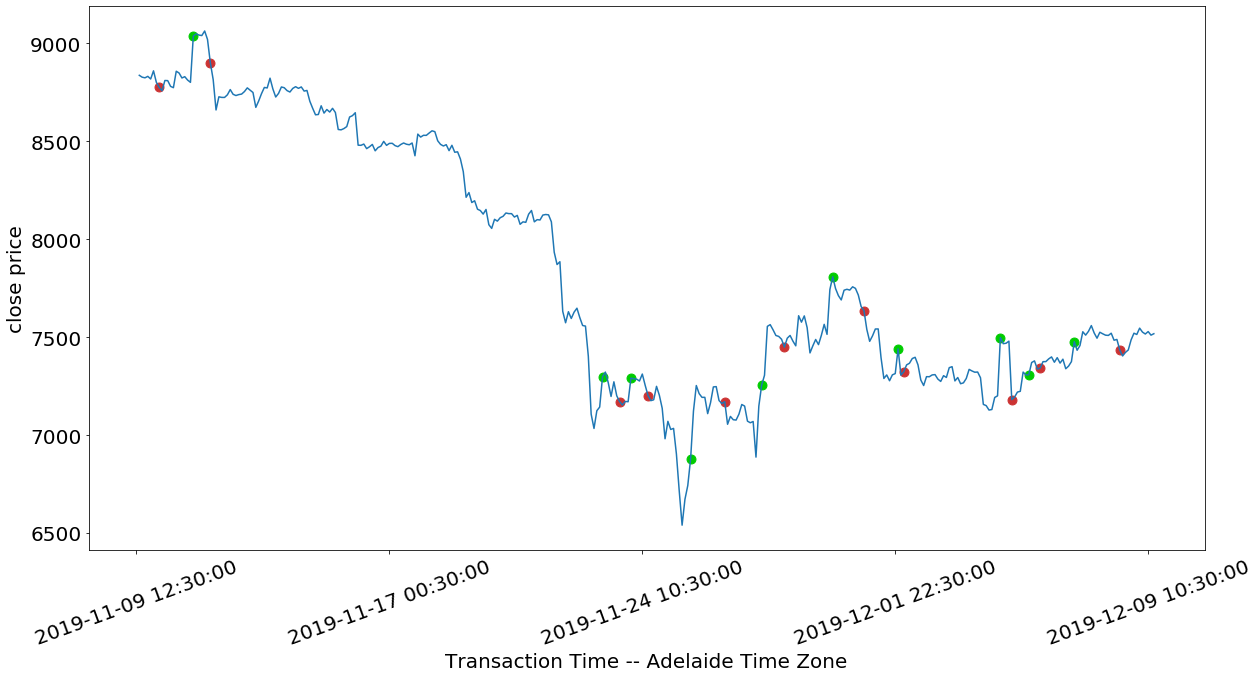

{Timestamp('2019-11-11 02:30:00'): 1, Timestamp('2019-11-11 14:30:00'): 2, Timestamp('2019-11-23 04:30:00'): 1, Timestamp('2019-11-23 16:30:00'): 2, Timestamp('2019-11-24 00:30:00'): 1, Timestamp('2019-11-24 12:30:00'): 2, Timestamp('2019-11-25 20:30:00'): 1, Timestamp('2019-11-26 20:30:00'): 2, Timestamp('2019-11-27 22:30:00'): 1, Timestamp('2019-11-28 14:30:00'): 2, Timestamp('2019-11-30 00:30:00'): 1, Timestamp('2019-11-30 22:30:00'): 2, Timestamp('2019-12-01 22:30:00'): 1, Timestamp('2019-12-02 02:30:00'): 2, Timestamp('2019-12-04 22:30:00'): 1, Timestamp('2019-12-05 06:30:00'): 2, Timestamp('2019-12-05 18:30:00'): 1, Timestamp('2019-12-06 02:30:00'): 2, Timestamp('2019-12-07 02:30:00'): 1, Timestamp('2019-12-08 10:30:00'): 2}


In [12]:
record = {}
run_bot('2h','2 hour','1 months ago UTC',record)

Initial money is:500
Initial bitcoin is:0
Initial bnb is:5
Investment Start Time:2019-11-09 14:30:00
Investment End Time:2019-12-09 10:30:00
Investment Periods: 29
Current Money:458.19816825
Current Bitcoin: 0
Current BNB: 4.763191792772083
Return on Investment is:-7.807521945780086%
Current Total Assert is: 543.9356205198975


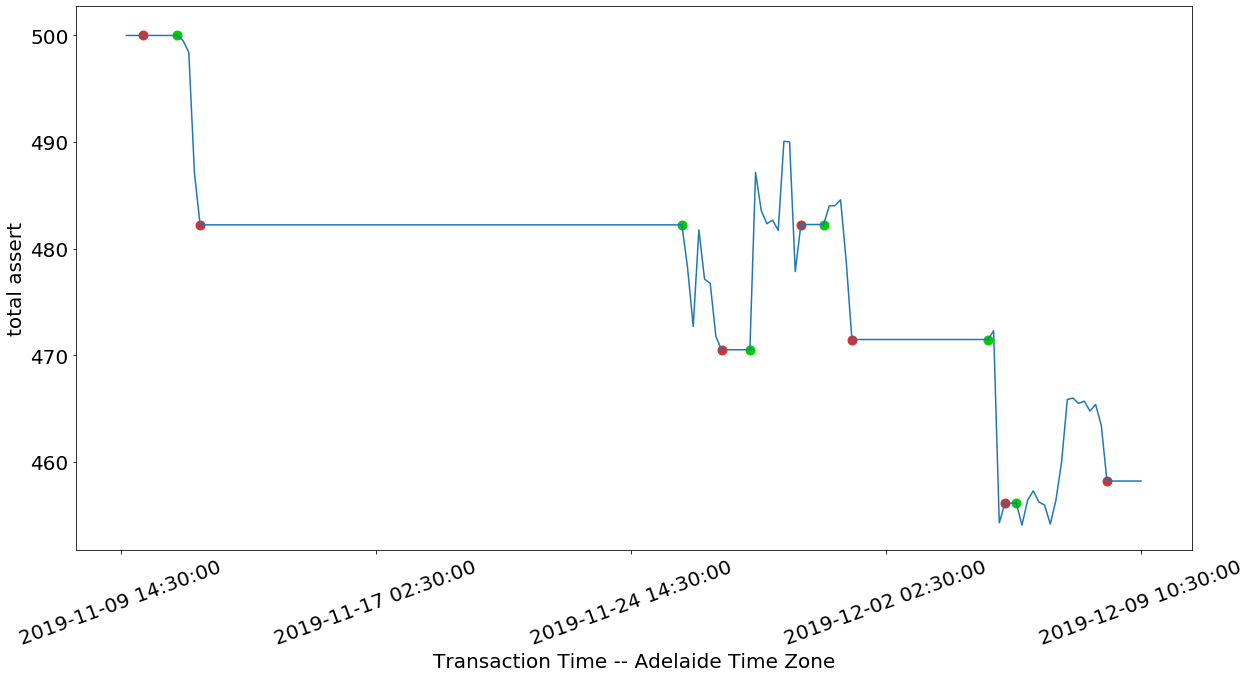

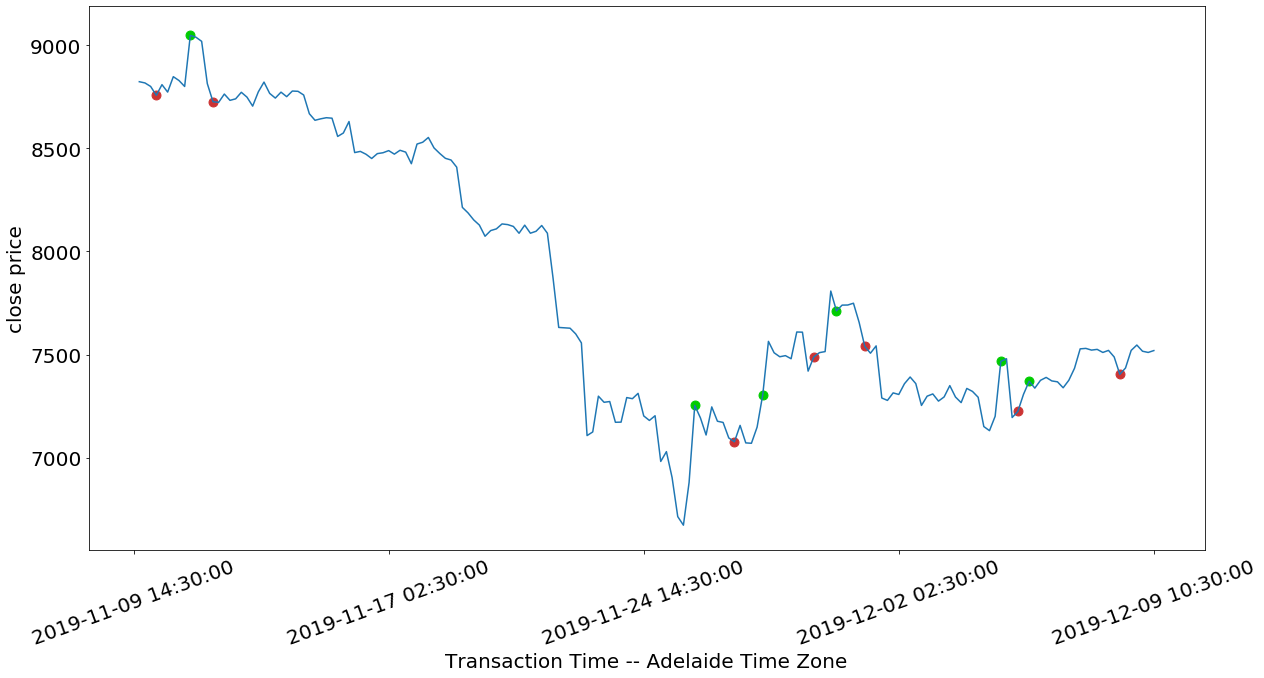

{Timestamp('2019-11-11 02:30:00'): 1, Timestamp('2019-11-11 18:30:00'): 2, Timestamp('2019-11-25 22:30:00'): 1, Timestamp('2019-11-27 02:30:00'): 2, Timestamp('2019-11-27 22:30:00'): 1, Timestamp('2019-11-29 10:30:00'): 2, Timestamp('2019-11-30 02:30:00'): 1, Timestamp('2019-11-30 22:30:00'): 2, Timestamp('2019-12-04 22:30:00'): 1, Timestamp('2019-12-05 10:30:00'): 2, Timestamp('2019-12-05 18:30:00'): 1, Timestamp('2019-12-08 10:30:00'): 2}


In [13]:
record = {}
run_bot('4h','4 hour','1 months ago UTC',record)

Initial money is:500
Initial bitcoin is:0
Initial bnb is:5
Investment Start Time:2019-11-09 16:30:00
Investment End Time:2019-12-09 10:30:00
Investment Periods: 29
Current Money:515.25501471
Current Bitcoin: 0
Current BNB: 4.914488783263334
Return on Investment is:2.3247140353796607%
Current Total Assert is: 603.71581280874


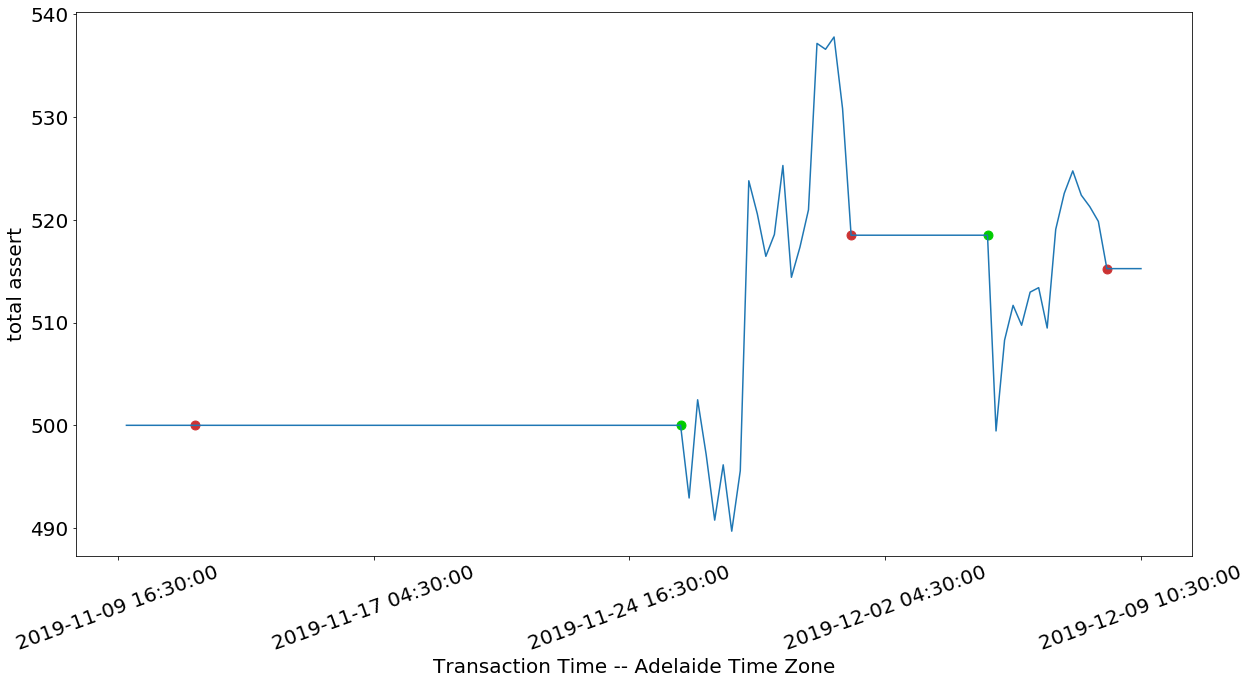

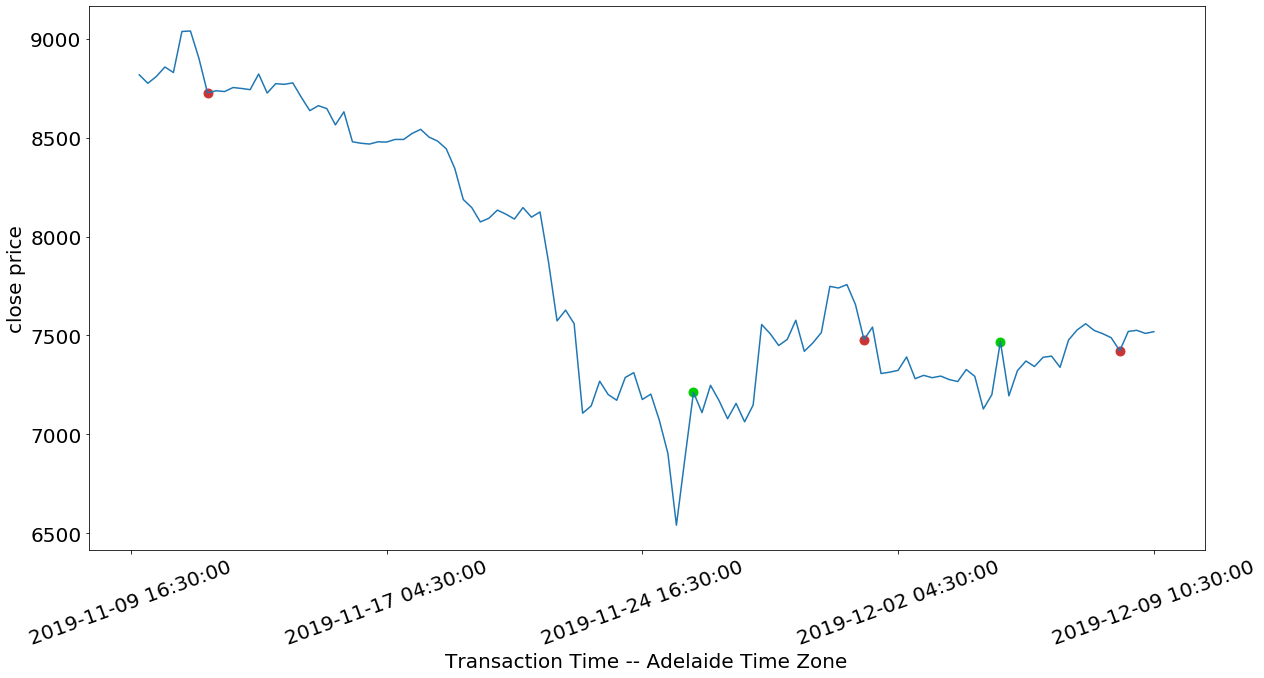

{Timestamp('2019-11-25 22:30:00'): 1, Timestamp('2019-11-30 22:30:00'): 2, Timestamp('2019-12-04 22:30:00'): 1, Timestamp('2019-12-08 10:30:00'): 2}


In [14]:
record = {}
run_bot('6h','6 hour','1 months ago UTC',record)

Initial money is:500
Initial bitcoin is:0
Initial bnb is:5
Investment Start Time:2019-11-09 22:30:00
Investment End Time:2019-12-09 10:30:00
Investment Periods: 29
Current Money:0.0019911200000137796
Current Bitcoin: 0.06902
Current BNB: 4.936667719528333
Return on Investment is:3.0127247578830603%
Current Total Assert is: 607.7750760715101


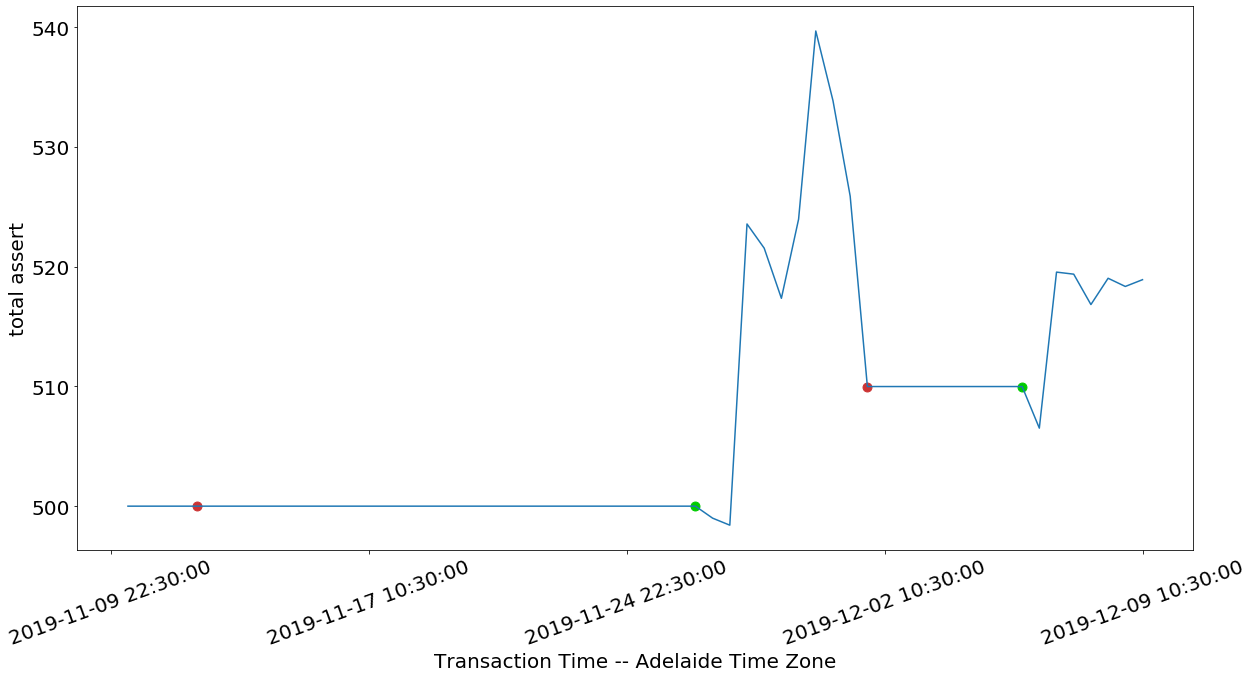

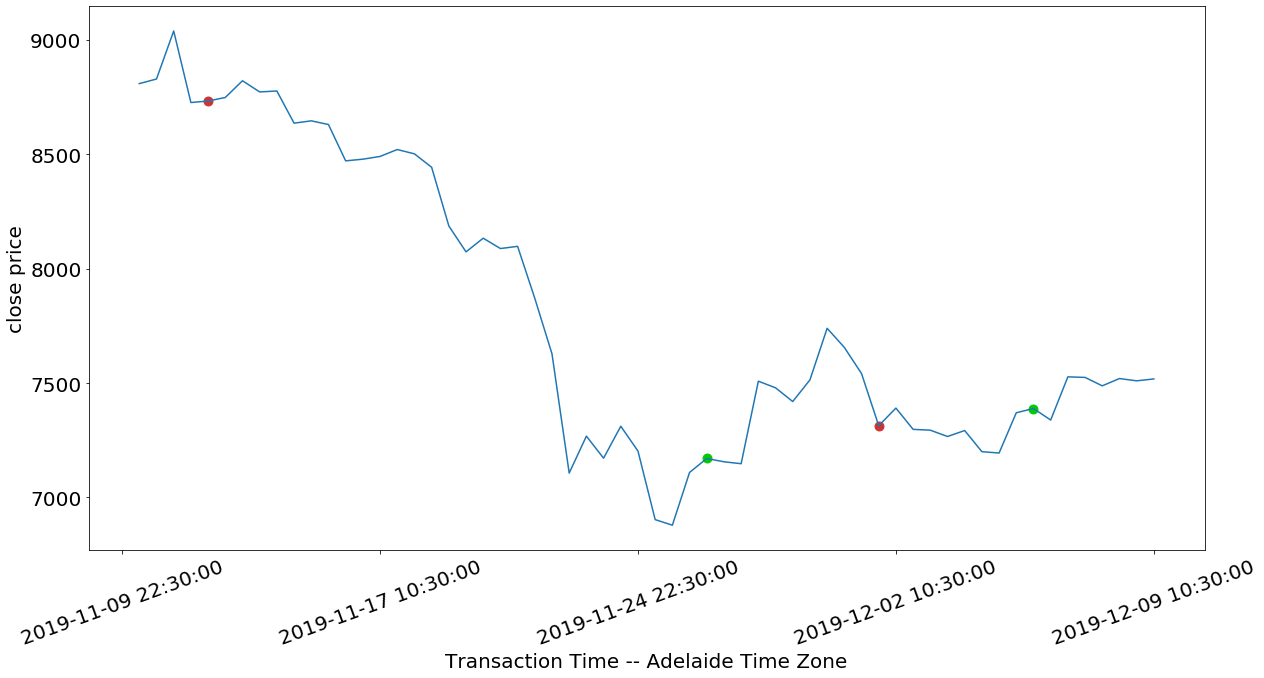

{Timestamp('2019-11-26 10:30:00'): 1, Timestamp('2019-12-01 10:30:00'): 2, Timestamp('2019-12-05 22:30:00'): 1}


In [15]:
record = {}
run_bot('12h','12 hour','1 months ago UTC',record)

Initial money is:500
Initial bitcoin is:0
Initial bnb is:5
Investment Start Time:2019-11-10 10:30:00
Investment End Time:2019-12-09 10:30:00
Investment Periods: 29
Current Money:0.0025385099999652994
Current Bitcoin: 0.066167
Current BNB: 4.937660636537501
Return on Investment is:-0.6208187512415322%
Current Total Assert is: 586.337169367675


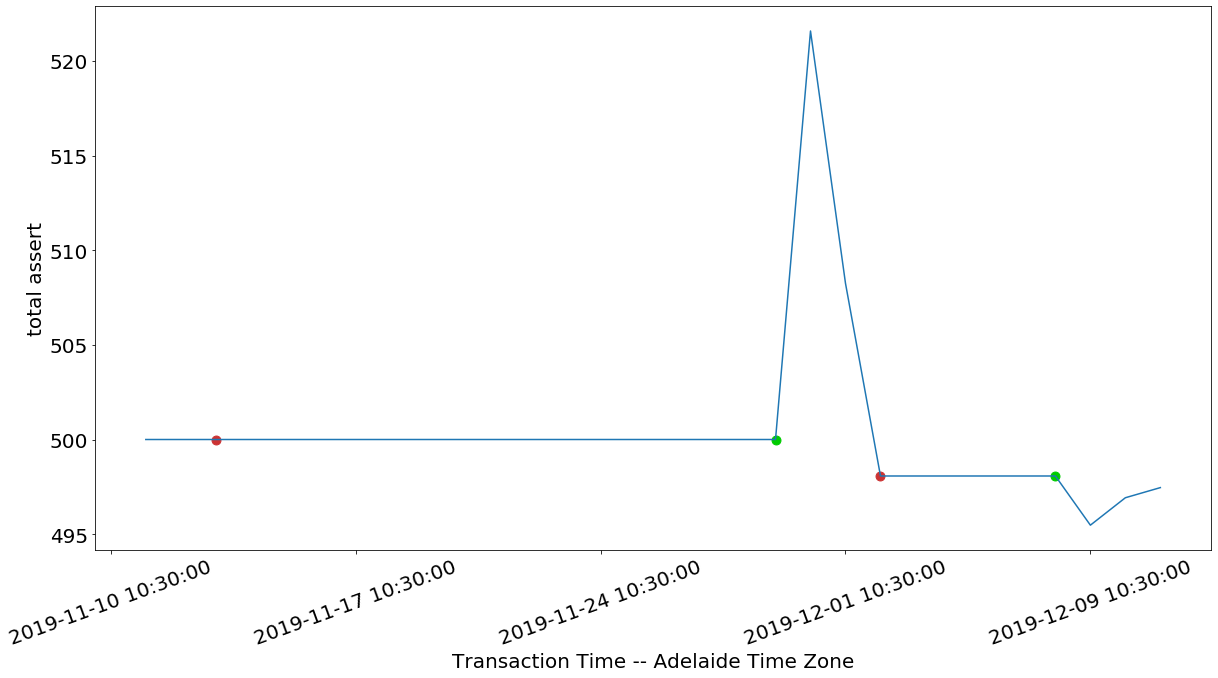

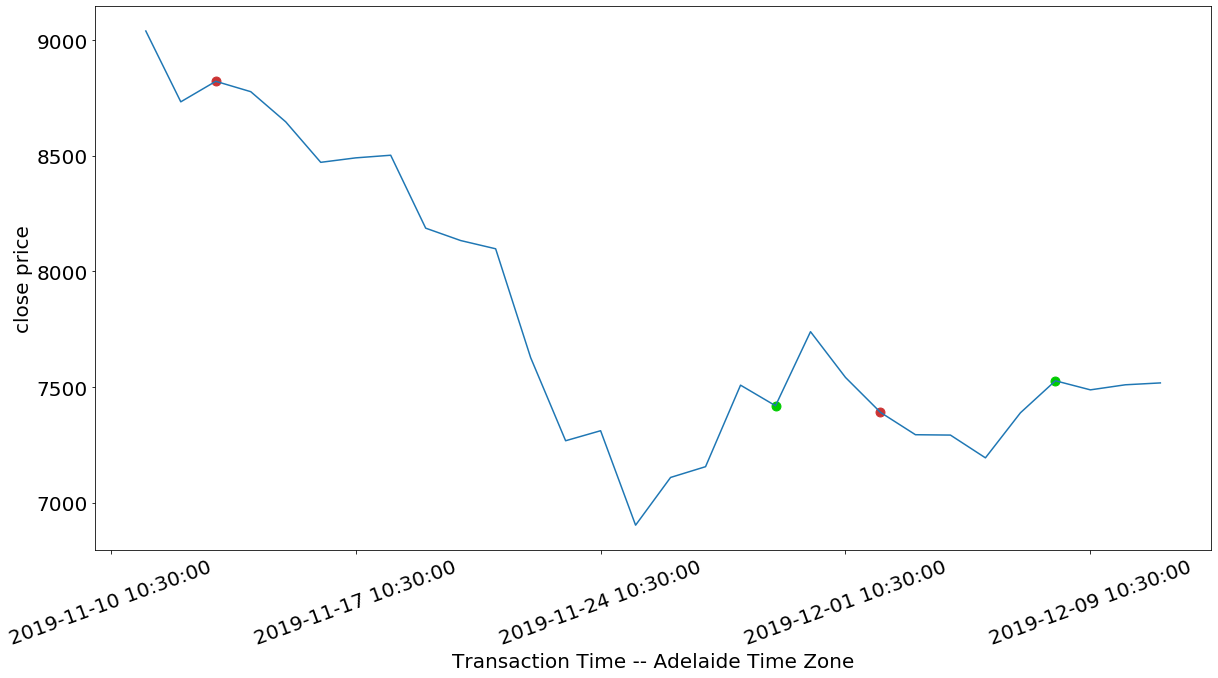

{Timestamp('2019-11-28 10:30:00'): 1, Timestamp('2019-12-01 10:30:00'): 2, Timestamp('2019-12-06 10:30:00'): 1}


In [16]:
record = {}
run_bot('1d','1 day','1 months ago UTC',record)